In [60]:

from functools import partial
from itertools import product
from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.pipeline import Pipeline
from friendly_guacamole.transforms import (
    FilterSamples,
    UniFrac,
    RarefactionBIOM,
    PCoA,
    AsDense,
    CLR,
)
from friendly_guacamole.datasets import KeyboardDataset
from umap import UMAP
from matplotlib.patches import Patch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [61]:
keyboard_data = KeyboardDataset('data/keyboard')
tree = keyboard_data.apply('tree', 'path')

RAREFACTION_DEPTH = 500

Files already downloaded and verified


In [62]:
min_count_filter = FilterSamples(min_count=RAREFACTION_DEPTH)
kb_mf = keyboard_data['metadata']
kb_table = keyboard_data['table']
kb_mf = kb_mf.set_index('sample_name')
metadata = kb_mf[kb_mf.host_subject_id.isin(['M2','M3', 'M9'])]
kb_table = kb_table.filter(metadata.index)
table = min_count_filter.fit_transform(kb_table)
metadata = metadata.loc[table.ids('sample')]

In [63]:
rarefied_table = RarefactionBIOM(RAREFACTION_DEPTH).fit_transform(table)

In [64]:
def postprocess_umap(results):
    return pd.DataFrame(results, columns=[f'PC{i + 1}'
                                          for i in range(results.shape[1])])

In [65]:
aitchison_pipeline = Pipeline([
    ('asdense', AsDense()),
    ('clr', CLR()),
])

In [172]:
aitchison_prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': aitchison_pipeline,
    },
]

prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': aitchison_pipeline,
    },
    {
        'name': 'Bray-Curtis',
        'metric': 'braycurtis',
        'pipeline': AsDense(),
    },
    {
        'name': 'Jaccard',
        'metric': 'jaccard',
        'pipeline': AsDense(),
    },
    {
        'name': 'UniFrac',
        'metric': 'precomputed',
        'pipeline': UniFrac(tree),
    },
    {
        'name': 'Weighted UniFrac',
        'metric': 'precomputed',
        'pipeline': UniFrac(tree,
                            unifrac_method='weighted_unnormalized'
                            ),
    },
]

In [67]:
embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
    },
    {
        'method': 'UMAP\nNeighbors=15',
        'pipeline': partial(UMAP,
                            # min_dist=0.5,
                            min_dist=1,
                            random_state=724
                            ),
        'postprocess': postprocess_umap,
    },
    {
        'method': 'UMAP\nNeighbors=80',
        'pipeline': partial(UMAP,
                            # min_dist=0.5,
                            min_dist=1,
                            n_neighbors=80,
                            random_state=825),
        'postprocess': postprocess_umap,
    },
]

In [155]:
results = dict()

for prep, emb in product(prep_tables, embedding_methods):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    results[(name, method)] = {'ordination': result}


/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.08975269131290496 and the largest is 10.542217394109498.
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavail

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns


In [157]:
v_position_map = {x['name']: i for i, x in enumerate(prep_tables)}
h_position_map = {x['method']: i for i, x in enumerate(embedding_methods)}

metadata['host_surface'] = metadata['host_subject_id'] + \
                           metadata['sample_type']


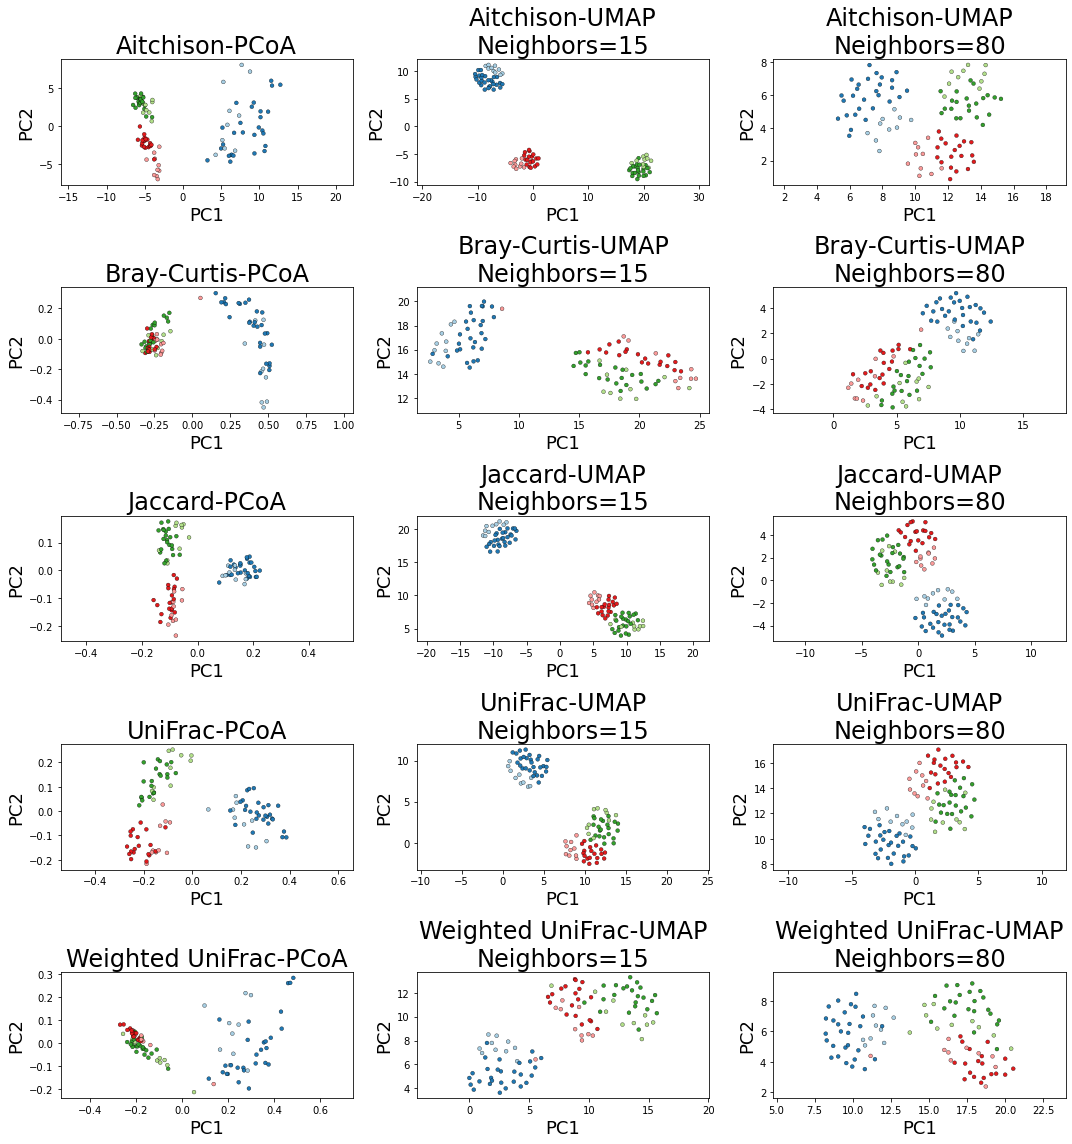

In [158]:
fig, axs = plt.subplots(len(v_position_map), len(h_position_map),
                        figsize=(15, 8 * 6 / 3),
                        )
for name, method in results:
        i = v_position_map[name]
        j = h_position_map[method]
        res = results[(name, method)]['ordination']
        res.index = metadata.index
        res = res.join(metadata)

        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue='host_surface',
            hue_order=list(sorted(metadata['host_surface'].unique())),
            # style='sample_type',
            data=res,
            ax=axs[i][j],
            s=15,
            edgecolor='k',
            palette='Paired',
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)

        g.set_xlabel('PC1', color='black', fontsize=18)
        g.set_ylabel('PC2', color='black', fontsize=18),

plt.tight_layout()
plt.savefig('results/2.0-real-data-keyboard-ordination.png', dpi=300)
plt.show()

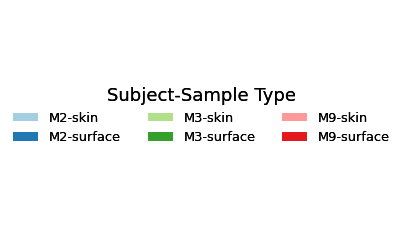

In [159]:
def add_legend(ax, pal, hue_order, patch_kwargs=None, legend_kwargs=None):
    if not legend_kwargs:
        legend_kwargs = dict()
    if not patch_kwargs:
        patch_kwargs = dict()

    palette = sns.color_palette(pal)
    legend_elements = []

    for i, name in enumerate(hue_order):
        new_element = Patch(
            facecolor=palette[i % len(palette)],
            label=name,
            **patch_kwargs,
        )
        legend_elements.append(new_element)

    legend = ax.legend(handles=legend_elements, **legend_kwargs)
    ax.add_artist(legend)
    return legend

fig, ax = plt.subplots()
unique = list(sorted(metadata['host_surface'].unique()))
unique = [u[:2] + '-' + u[2:] for u in unique]

add_legend(ax, 'Paired', unique,
           patch_kwargs=dict(
               edgecolor='w',
               linewidth=1,
           ),
           legend_kwargs=dict(
               loc='center',
               fontsize=13, ncol=3, framealpha=0.0,
               title='Subject-Sample Type',
               title_fontsize=18,
           )
)
ax.axis('off')
plt.savefig('results/2.0-real-data-keyboard-ordination-legend.png', dpi=300)
plt.show()

In [160]:
from skbio.stats.distance import permanova
from skbio import DistanceMatrix

In [161]:
def get_numeric_index_matching(metadata, category, value):
    new_index = metadata[category].reset_index(drop=True)
    matches = new_index == value
    return new_index.index[matches]

In [173]:
repeat_embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
    },
]

for i in range(10):
    new_methods = [
        {
            'method': 'UMAP\nNeighbors=15',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                random_state=724 + i,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=80',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_neighbors=80,
                                random_state=825 + i
                                ),
            'postprocess': postprocess_umap,
        },
    ]
    repeat_embedding_methods.extend(new_methods)

In [183]:
repeat_results = dict()

for i, (prep, emb) in enumerate(product(aitchison_prep_tables,
                                repeat_embedding_methods)):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    repeat_results[(i, name, method)] = {'ordination': result}

In [184]:
model = LinearDiscriminantAnalysis()

for (i, name, method), result in repeat_results.items():
    first_pcs = result['ordination'].loc[:, ['PC1', 'PC2']]
    grouping = metadata['host_subject_id']
    model.fit(first_pcs, grouping)
    stats_result = model.score(first_pcs, grouping)

    result_key = 'within_subject_clustering_model'
    result[result_key] = {'overall': stats_result}
    for subject in metadata['host_subject_id'].unique():
        idx = get_numeric_index_matching(metadata, 'host_subject_id', subject)
        sub_metadata = metadata.iloc[idx]
        sub_pcs = first_pcs.iloc[idx]
        sub_target = sub_metadata['sample_type']
        model.fit(sub_pcs, sub_target)
        stats_result = model.score(sub_pcs, sub_target)
        result[result_key][subject] = stats_result

for (i, name, method), result in repeat_results.items():
    result['model statistics'] = dict()
    result['model statistics']['host'] = \
        result['within_subject_clustering_model']['overall']
    for subject in metadata['host_subject_id'].unique():
        stat = result['within_subject_clustering_model'][subject]
        result['model statistics'][f'{subject}-type'] = stat

model_statistics = dict()
for (i, name, method), result in repeat_results.items():
    model_statistics[(i, name, method)] = result['model statistics']

In [194]:
pd.DataFrame(model_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
}, axis=1).T.reset_index().drop(
    'level_0', axis=1
).groupby(
    ['level_1', 'level_2']
).agg(['mean', 'std']).round(3)

host      M2-type        M3-type        M9-type  \
                             mean  std    mean    std    mean    std    mean   
level_1   level_2                                                              
Aitchison PCoA               0.99  NaN   0.789    NaN   0.781    NaN   0.931   
          UMAP Neighbors=15  1.00  0.0   0.974  0.012   0.856  0.049   0.990   
          UMAP Neighbors=80  1.00  0.0   0.992  0.013   0.831  0.059   0.969   

                                    
                               std  
level_1   level_2                   
Aitchison PCoA                 NaN  
          UMAP Neighbors=15  0.017  
          UMAP Neighbors=80  0.025

In [141]:
for (name, method), result in results.items():
    first_pcs = result['ordination'].loc[:, ['PC1', 'PC2']]
    dm_on_first_pcs = cdist(first_pcs, first_pcs)
    result['distance_matrix'] = DistanceMatrix(dm_on_first_pcs)
    # compute the permanova for the clusters
    grouping = metadata['host_subject_id']
    stats_result = permanova(result['distance_matrix'], grouping)

    result_key = 'within_subject_clustering_test'
    result[result_key] = {'overall': stats_result}
    for subject in metadata['host_subject_id'].unique():
        idx = get_numeric_index_matching(metadata, 'host_subject_id', subject)
        sub_metadata = metadata.iloc[idx]
        sub_dm = result['distance_matrix'][:, idx][idx, :]
        stats_result = permanova(
            DistanceMatrix(sub_dm),
            sub_metadata['sample_type']
        )
        result[result_key][subject] = stats_result

for (name, method), result in results.items():
    result['test statistics'] = dict()
    result['test statistics']['host'] = result['within_subject_clustering_test']['overall']['test statistic']
    for subject in metadata['host_subject_id'].unique():
        stat = result['within_subject_clustering_test'][subject]['test statistic']
        result['test statistics'][f'{subject}-type'] = stat

test_statistics = dict()
for (name, method), result in results.items():
    test_statistics[(name, method)] = result['test statistics']

In [78]:
pd.DataFrame(test_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
}, axis=1).T.round(2)



host  M2-type  M3-type  M9-type
Aitchison        PCoA                253.46     3.26     6.32    49.00
                 UMAP Neighbors=15  3186.55    16.23    12.96    32.11
                 UMAP Neighbors=80   176.22    16.67    11.76    23.14
Bray-Curtis      PCoA                190.07    13.21     2.05     5.84
                 UMAP Neighbors=15   302.35    14.69     2.98     0.59
                 UMAP Neighbors=80   167.44    12.55     2.27     2.13
Jaccard          PCoA                422.84     4.64     2.69     4.10
                 UMAP Neighbors=15  1815.73    13.49     3.07    24.89
                 UMAP Neighbors=80   217.72    16.56     4.46    32.93
UniFrac          PCoA                338.04     6.63     6.16     8.14
                 UMAP Neighbors=15   589.92    13.39     4.68    32.88
                 UMAP Neighbors=80   170.40    14.83     4.03    27.31
Weighted UniFrac PCoA                172.91     3.57     4.58     5.03
                 UMAP Neighbors=15   260.28    10.60     3.03     7.89
                 UMAP Neighbors=80   196.27    11.51     4.12     4.42

In [79]:
import numpy as np
from matplotlib.colors import rgb2hex
from numpy import ma
from scipy.stats import hmean, gmean
import matplotlib as mpl
from matplotlib.colors import Normalize

In [80]:
a = np.array([1, 20, 0, 1])
b = 1 / a

<ipython-input-80-46db7fbe3c66>:2: RuntimeWarning: divide by zero encountered in true_divide
  b = 1 / a


In [81]:
ma.masked_array(a, mask=a == 0).mean()

7.333333333333333

In [82]:
from distortion import (
    distortion,
    pairwise_ratios,
    mean_absolute_distortion,
)

In [83]:
raw_aitchison_coord = aitchison_pipeline.fit_transform(table)
raw_aitchison_dm = cdist(raw_aitchison_coord, raw_aitchison_coord)

In [84]:
aitchison_results = list(filter(lambda x: x[0][0] == 'Aitchison', results.items()))
all_distortions = []
all_ratios = []
all_normalized_distance_ratios = []

for (name, method), result in aitchison_results:
    embedding_dm = result['distance_matrix']
    distance_ratios = pairwise_ratios(raw_aitchison_dm, embedding_dm[:, :])
    np.fill_diagonal(distance_ratios, 1)
    result['distance_ratios'] = distance_ratios
    distortion_values = distortion(raw_aitchison_dm, embedding_dm[:, :],
                                   kind='worst',
                                   # measure_kwargs={'alpha_method': 'worst'},
                                   axis=0,
                                   )
    result['distortion_values'] = distortion_values

    ratiomat = result['distance_ratios']
    logratios = np.log2(ratiomat)
    geom_mean = logratios[np.triu_indices_from(logratios, k=1)].mean()
    logratios = logratios - geom_mean
    np.fill_diagonal(logratios, 0)
    result['distance_ratios_normalized'] = logratios
    # all_dist = np.hstack([embedding_dm[:, :].flatten(), raw_aitchison_dm
    #                      .flatten()]).transpose()
    # g = sns.violinplot(
    #     y=all_dist,
    #     x=np.hstack([np.repeat(['embedding'], embedding_dm[:, :].size),
    #                  np.repeat(['original'], raw_aitchison_dm.size)
    #                  ]).transpose(),
    # )
    # g.set_title(method)
    # plt.show()
    all_ratios.append(distance_ratios)

    all_distortions.append(distortion_values)
    all_normalized_distance_ratios.append(logratios)

all_distortions = np.hstack(all_distortions)
all_ratios = np.hstack(all_ratios)
all_normalized_distance_ratios = np.hstack(all_normalized_distance_ratios)
max_normalized_ratio = all_normalized_distance_ratios.max()
min_normalized_ratio = all_normalized_distance_ratios.min()
max_ratio = all_ratios.max()
min_ratio = all_ratios.min()

In [85]:
mean_absolute_distortion(raw_aitchison_dm, result['distance_matrix'][:, :])

/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:41: RuntimeWarning: divide by zero encountered in log2
  logratios = np.log2(ratios)


0.5734316417446518

In [86]:
from scipy.cluster import hierarchy

<ipython-input-87-d29be83add94>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(raw_aitchison_dm, method='average',


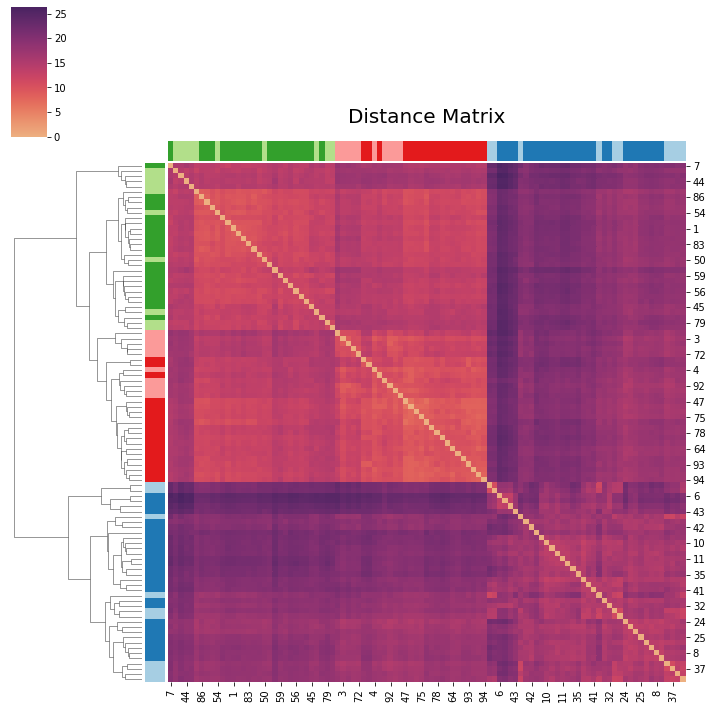

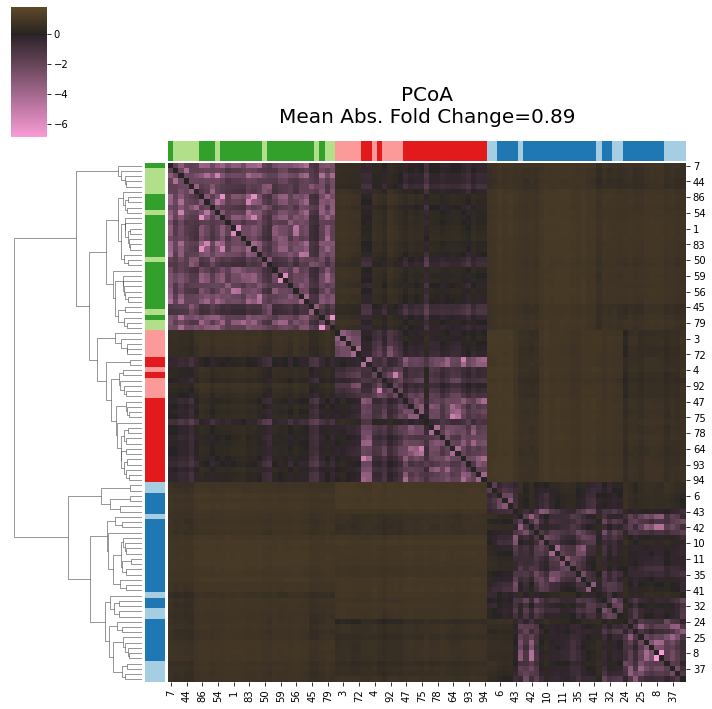

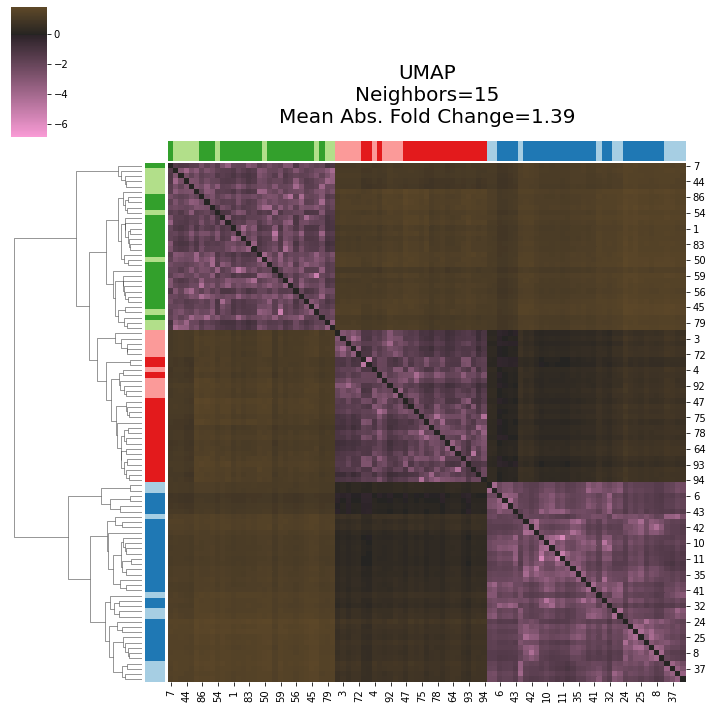

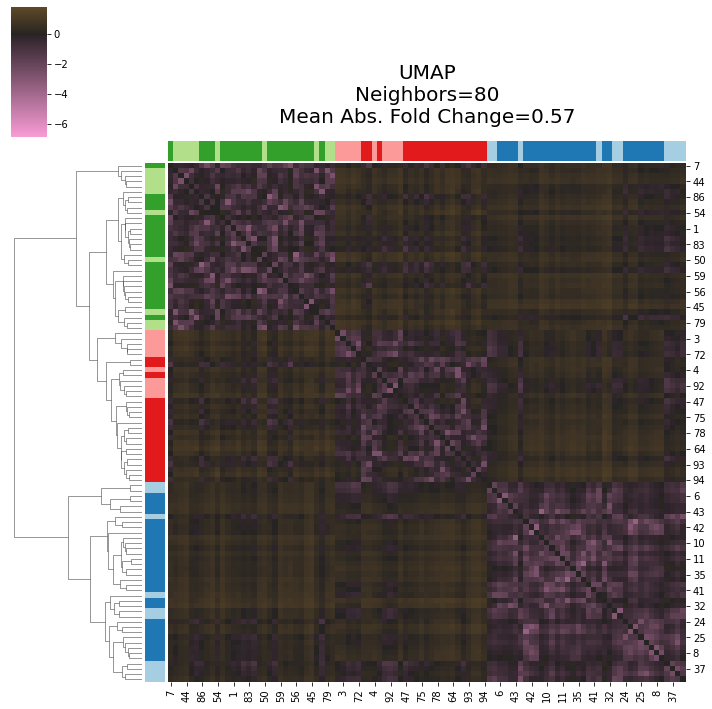

In [87]:
palette = sns.color_palette('Paired')
hues_ordered = list(sorted(metadata['host_surface'].unique()))
linkage = hierarchy.linkage(raw_aitchison_dm, method='average',
                            metric='braycurtis')
map_hue = {val: palette[i] for i, val in enumerate(hues_ordered)}
g = sns.clustermap(
    raw_aitchison_dm,
    row_linkage=linkage,
    col_linkage=linkage,
    col_colors=list(map(map_hue.get, res['host_surface'].to_numpy())),
    row_colors=list(map(map_hue.get, res['host_surface'].to_numpy())),
    cmap='flare'
)
g.ax_col_dendrogram.set_visible(False)
g.ax_heatmap.set_title('Distance Matrix',
                       fontsize=20, pad=40)

for (name, method), result in aitchison_results:
    res = result['ordination']
    res.index = metadata.index
    res = res.join(metadata)

    cmap = sns.diverging_palette(
        330,
        49,
        s=90,
        l=75,
        center='dark',
        as_cmap=True,
    )
    logratios = result['distance_ratios_normalized']

    g = sns.clustermap(
        logratios,
        col_colors=list(map(map_hue.get, res['host_surface'].to_numpy())),
        row_colors=list(map(map_hue.get, res['host_surface'].to_numpy())),
        cmap=cmap,
        # vmin=-1,
        # vmax=1,
        vmax=max_normalized_ratio,
        vmin=min_normalized_ratio,
        center=0,
        row_linkage=linkage,
        col_linkage=linkage,
    )
    g.ax_col_dendrogram.set_visible(False)
    triu_ratios = logratios[np.triu_indices_from(logratios, k=1)]
    std = triu_ratios.std()
    mse = np.abs(triu_ratios).mean()
    g.ax_heatmap.set_title(method +
                           # f'\nSTD={std:.2f}' +
                           f'\nMean Abs. Fold Change={mse:.2f}',
                           fontsize=20, pad=40)
    # g.set_title(method)


In [88]:
min_distortion = all_distortions.min()
max_distortion = all_distortions.max()
normalize = Normalize(vmin=min_distortion, vmax=max_distortion)

# middle =

cmap = sns.color_palette('Reds', as_cmap=True)

for (name, method), result in aitchison_results:
    distortion_values = result['distortion_values']
    min_distortion = distortion_values.min()
    max_distortion = distortion_values.max()
    distortion_values = (result['distortion_values'] - min_distortion) / \
                        (max_distortion - min_distortion)
    result['distortion_values'] = distortion_values
    result['distortion_colors'] = cmap(distortion_values.astype(float))
    # print(result['distortion_values'], result['distortion_colors'])



In [143]:
def umaps_with_seed(seed):
    return [
        {
            'method': 'UMAP\nNeighbors=15',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_neighbors=15,
                                random_state=seed,
                                ),
            'postprocess': postprocess_umap,
            'prep': aitchison_pipeline,
        },
        {
            'method': 'UMAP\nNeighbors=80',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_neighbors=80,
                                random_state=seed),
            'postprocess': postprocess_umap,
            'prep': aitchison_pipeline,
        },
    ]

seed = 724
cluster_distortion_results = {}
for seed in range(50):
    for embedding_method in umaps_with_seed(seed):
        metric = 'euclidean'
        name = embedding_method['method']
        prepped_table = embedding_method['prep'].fit_transform(table)
        transformer = embedding_method['pipeline'](metric=metric)
        embedding = transformer.fit_transform(prepped_table)
        result = embedding_method.get('postprocess', lambda x: x)(embedding)
        cluster_distortion_results[(name, seed)] = {'ordination': result}
        res = result
        res.index = metadata.index
        res = res.join(metadata['host_subject_id'])

        centroids = res.groupby('host_subject_id').mean().loc[['M2', 'M3', 'M9']]
        centroid_distances = cdist(centroids, centroids)

        m2m3 = centroid_distances[0, 1]
        m2m9 = centroid_distances[0, 2]
        m3m9 = centroid_distances[1, 2]
        distances_wrong = (m2m3 < m3m9) or (m2m9 < m3m9)
        cluster_distortion_results[(name, seed)]['centroids_distorted'] = distances_wrong

In [144]:
df = pd.DataFrame(cluster_distortion_results).T
df.index.set_names(['method', 'seed'], inplace=True)
df['centroids_distorted'] = df['centroids_distorted'].astype(float)
df.reset_index().groupby('method')['centroids_distorted'].mean()
df.reset_index().groupby('method')['centroids_distorted'].sum()

method
UMAP\nNeighbors=15    16.0
UMAP\nNeighbors=80     0.0
Name: centroids_distorted, dtype: float64

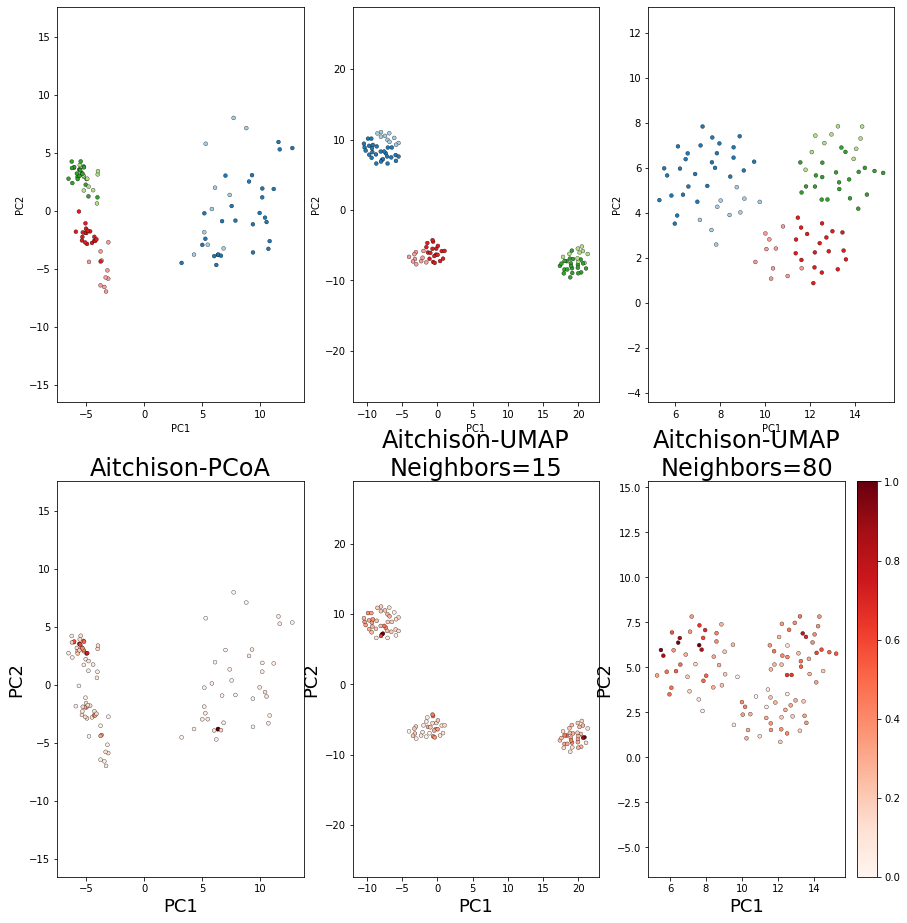

In [105]:
fig, axs = plt.subplots(2, len(h_position_map),
                        figsize=(15, 8 * 6 / 3),
                        )


for (name, method), result in aitchison_results:
    i = 0
    j = h_position_map[method]
    res = results[(name, method)]['ordination']
    res.index = metadata.index
    res = res.join(metadata)
    # res['distortion'] = result['distortion_colors']

    g = sns.scatterplot(
        x='PC1',
        y='PC2',
        hue='host_surface',
        hue_order=list(sorted(metadata['host_surface'].unique())),
        # style='sample_type',
        data=res,
        ax=axs[0][j],
        s=15,
        edgecolor='k',
        palette='Paired',
    )
    g.set_aspect('equal', 'datalim')
    g.legend().remove()

    g = sns.scatterplot(
        x='PC1',
        y='PC2',
        hue=[rgb2hex(c) for c in result['distortion_colors']],
        palette={rgb2hex(c): rgb2hex(c) for c in result['distortion_colors']},
        # hue_order=list(sorted(metadata['host_surface'].unique())),
        # style='sample_type',
        data=res,
        ax=axs[1][j],
        s=15,
        edgecolor='k',
        legend=False,
        # palette=sns.color_palette('viridis', as_cmap=True),
    )
    g.set_aspect('equal', 'datalim')
    # g.legend().remove()


    g.set_title(f'{name}-{method}',
                color='black',
                fontsize=24)

    g.set_xlabel('PC1', color='black', fontsize=18)
    g.set_ylabel('PC2', color='black', fontsize=18),

sm = plt.cm.ScalarMappable(cmap=cmap)

plt.colorbar(sm)

# plt.savefig('results/keyboard-aitchison-with-distortion-plots.png', dpi=300)